In [2]:
#開啟 colab google硬碟
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
#固定圖片大小 100 x100, 處理0代表CLL, 1代表MCL, 2代表FL
IMG_SIZE = 100
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

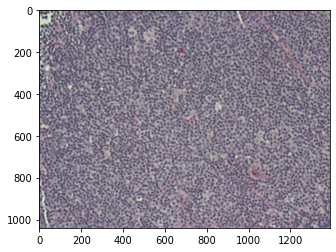

In [7]:
# Read single image, 抓取 Lymphoma裏面所有 .tif 結尾的檔案
data_path = 'drive/My Drive/Day4/lymphoma/*/*.tif' 
# glob 用於把符合路徑的檔案全抓出來
img_paths = glob(data_path)
img_paths = np.random.choice(img_paths, 100) # demo for 100 images

img = cv2.imread(img_paths[0])
img = img[:,:,::-1] # BGR -> RGB, 色彩深度原本是 BGR, 顯示圖的套劍 matplot 需要轉成 RGB方式
plt.imshow(img)

((1040, 1388, 3), (100, 100, 3))

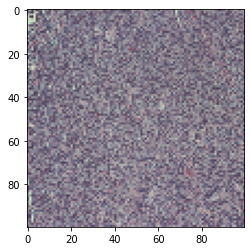

In [8]:
# Resize img, 把圖的大小改成 100x100
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [9]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/Day4/lymphoma/CLL/sj-05-3165_011.tif'

In [10]:
cls = img_path.split('/')[-2]
cls

'CLL'

In [11]:
class_map[cls]

0

In [0]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [14]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)
    img = img / 255. # normalize 0~255 -> 0~1
    img = img[:,:,::-1] #BGR -> RGB
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [15]:
# label count, 檢視類別分布
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 28, 1.0: 30, 2.0: 42}

In [0]:
# X = X/255
y_onehot = keras.utils.to_categorical(y, num_classes=3)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 100, 100, 3), (20, 100, 100, 3), (80, 3), (20, 3))

In [0]:
# 1, 相較於 sequential 這個方法較有彈性, shape 在深度學習需要特別注意, 圖片大小需要對的上才能跑
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#把 input 丟到 3x3濾鏡 總共有16層的過濾器內
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=17, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=31, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
#把上述的結果拉成1D向量,
x = Flatten()(x)
#丟到MLP裏面
x = Dense(64, activation=keras.activations.relu)(x)
#有三個東西, 機率加總是1, 用softmax
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 17)        2465      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 17)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 31)        4774      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 32)        8960      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0   

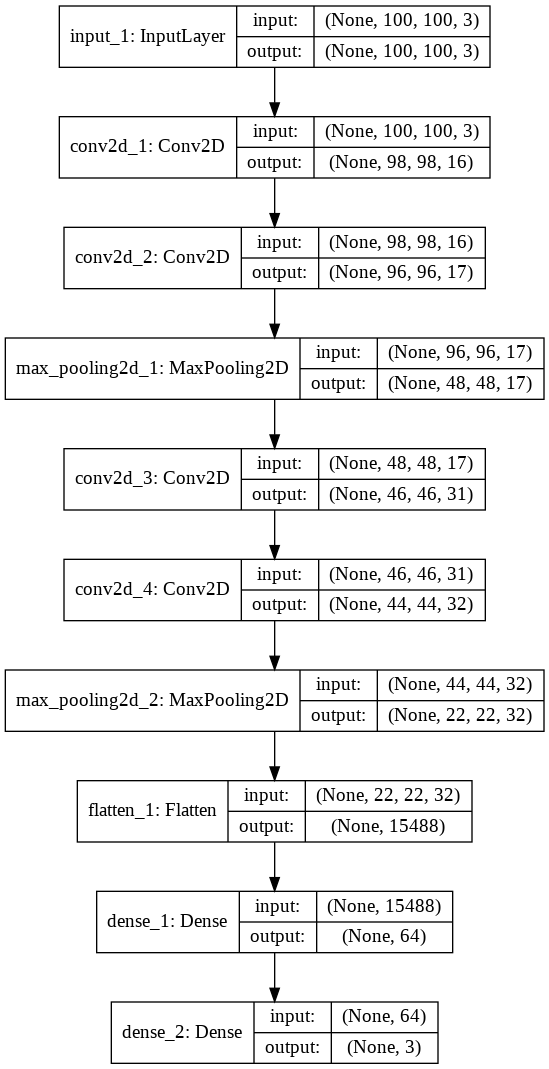

In [24]:
# 劃出模型
keras.utils.plot_model(model, show_shapes=True)

In [0]:
# loss用於設定用甚麼方法查看與目標值的差異, 
# optimizer是計算出差距之後, 用甚麼方法更新模型-->adam, 用動量方式處理
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [27]:
# batch_size 一次要訓練幾筆資料(GPU記憶體越大可以塞越多), 
# epochs 總共要訓練幾次(看完所有訓練資料一次叫一輪, 這邊是看完所有訓練資料20便)
# verbose 1->輸出進度條, 0->不顯示 2->只輸出進度沒有條
# validation_data 是每一次訓練完之後, 拿他沒看過的資料給他考試 
logs = model.fit(X_train, y_train,
                batch_size=32,
                epochs=20,
                verbose=1,
                validation_data=(X_test, y_test))

Train on 80 samples, validate on 20 samples
Epoch 1/20
80/80 [==============================] - 0s 842us/step - loss: 0.5552 - accuracy: 0.8125 - val_loss: 0.9185 - val_accuracy: 0.5500
Epoch 2/20
80/80 [==============================] - 0s 828us/step - loss: 0.5491 - accuracy: 0.8625 - val_loss: 0.8914 - val_accuracy: 0.6500
Epoch 3/20
80/80 [==============================] - 0s 784us/step - loss: 0.4827 - accuracy: 0.8125 - val_loss: 0.8285 - val_accuracy: 0.5500
Epoch 4/20
80/80 [==============================] - 0s 868us/step - loss: 0.4213 - accuracy: 0.9125 - val_loss: 1.0532 - val_accuracy: 0.5000
Epoch 5/20
80/80 [==============================] - 0s 876us/step - loss: 0.3806 - accuracy: 0.9000 - val_loss: 0.8112 - val_accuracy: 0.6500
Epoch 6/20
80/80 [==============================] - 0s 787us/step - loss: 0.3751 - accuracy: 0.8750 - val_loss: 1.2825 - val_accuracy: 0.4000
Epoch 7/20
80/80 [==============================] - 0s 808us/step - loss: 0.4023 - accuracy: 0.8875 - va

In [29]:
# 每一個訓練跟測驗過程的數值
history = logs.history
history

{'accuracy': [0.8125,
  0.8625,
  0.8125,
  0.9125,
  0.9,
  0.875,
  0.8875,
  0.825,
  0.95,
  0.975,
  1.0,
  0.9875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [0.5552090167999267,
  0.5490525126457214,
  0.4827477872371674,
  0.42127281427383423,
  0.3806000888347626,
  0.37505786418914794,
  0.40230627059936525,
  0.32180638909339904,
  0.3009753912687302,
  0.22722491025924682,
  0.15998784303665162,
  0.15884860157966613,
  0.10162805020809174,
  0.08738077282905579,
  0.06366969123482705,
  0.04211115464568138,
  0.03315957635641098,
  0.02615664675831795,
  0.023868077620863914,
  0.015960389375686647],
 'val_accuracy': [0.550000011920929,
  0.6499999761581421,
  0.550000011920929,
  0.5,
  0.6499999761581421,
  0.4000000059604645,
  0.6000000238418579,
  0.550000011920929,
  0.6499999761581421,
  0.6499999761581421,
  0.6499999761581421,
  0.6499999761581421,
  0.550000011920929,
  0.550000011920929,
  0.5,
  0.6000000238418579,
  0.6000000238418579,
 

Text(0.5, 1.0, 'acc')

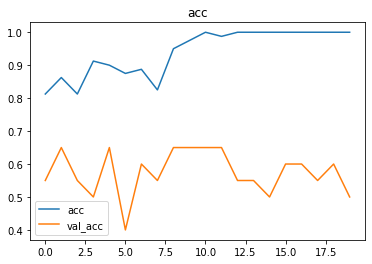

In [30]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

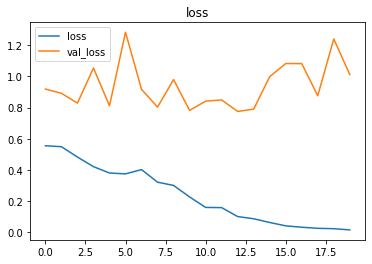

In [31]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(3)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


(20,) (20,)
              precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.60      0.38      0.46         8
           2       0.60      0.75      0.67         8

    accuracy                           0.50        20
   macro avg       0.47      0.46      0.45        20
weighted avg       0.52      0.50      0.50        20

[[1 2 1]
 [2 3 3]
 [2 0 6]]
